In [3]:
def bolinger(name):
    name['ave'] =  name["Adj Close"].rolling(window=10, center = False).mean()
    sd =  name["Adj Close"].rolling(window=10, center = False).std()
    name['upper'] = name['ave'] + (sd*2)
    name['lower'] = name['ave'] - (sd*2)
    pandas_candlestick_ohlc(name.loc['2016-01-04':'2017-02-01',:], otherseries = ["ave","upper","lower"])

# compare stocks with a lot of news to those without. there are patterns when no fluctuations derp.

def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

#tesla["test"]=rsiFunc(tesla["Adj Close"])
#tesla["test"].plot(grid=True)

#bolinger(tesla)

def pandas_candlestick_ohlc(dat, stick = "day", otherseries = None):
    """
    :param dat: pandas DataFrame object with datetime64 index, and float columns "Open", "High", "Low", and "Close", likely created via DataReader from "yahoo"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines

    This will show a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12

    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                            "High": max(group.High),
                                            "Low": min(group.Low),
                                            "Close": group.iloc[-1,3]},
                                           index = [group.index[0]]))
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365

    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            plotdat = plotdat.append(pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                       index = [group.index[0]]))

    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')


    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)

    ax.grid(True)

    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "black", colordown = "red", width = stick * .4)

    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)

    ax.xaxis_date()
    ax.autoscale_view()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.show()

    
def profitt(temp,stoploss):
    stop_trig=False
    n=len(temp)
    for val in temp:
        if (temp[0]*(1-stoploss))> val:
                share_profit=val-temp[0]
                stop_trig = True
                return (stop_trig,share_profit)
  
        
        
    if stop_trig != True:
        share_profit=row["Profit"]
        #share_profit=temp[n-1]-temp[0]
        
        
        return (stop_trig,share_profit)
def ohlc_adj(dat):
    """
    :param dat: pandas DataFrame with stock data, including "Open", "High", "Low", "Close", and "Adj Close", with "Adj Close" containing adjusted closing prices

    :return: pandas DataFrame with adjusted stock data

    This function adjusts stock data for splits, dividends, etc., returning a data frame with
    "Open", "High", "Low" and "Close" columns. The input DataFrame is similar to that returned
    by pandas Yahoo! Finance API.
    """
    return pd.DataFrame({"Open": dat["Open"] * dat["Close"] / dat["Close"],
                       "High": dat["High"] * dat["Close"] / dat["Close"],
                       "Low": dat["Low"] * dat["Close"] / dat["Close"],
                       "Close": dat["Close"]})


def rsiFunc(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def ma_crossover_orders(stocks, fast, slow):
    """
    :param stocks: A list of tuples, the first argument in each tuple being a string containing the ticker symbol of each stock (or however you want the stock represented, so long as it's unique), and the second being a pandas DataFrame containing the stocks, with a "Close" column and indexing by date (like the data frames returned by the Yahoo! Finance API)
    :param fast: Integer for the number of days used in the fast moving average
    :param slow: Integer for the number of days used in the slow moving average

    :return: pandas DataFrame containing stock orders

    This function takes a list of stocks and determines when each stock would be bought or sold depending on a moving average crossover strategy, returning a data frame with information about when the stocks in the portfolio are bought or sold according to the strategy
    """
    fast_str = str(fast) + 'd'
    slow_str = str(slow) + 'd'
    ma_diff_str = fast_str + '-' + slow_str

    trades = pd.DataFrame({"Price": [], "Regime": [], "Signal": []})
    for s in stocks:
        
        # Get the moving averages, both fast and slow, along with the difference in the moving averages
        s[1][fast_str] = s[1]["Close"].rolling(window = fast, center = False).mean()
        s[1][slow_str] = s[1]["Close"].rolling(window = slow, center = False).mean() 
        s[1][ma_diff_str] = s[1][fast_str] - s[1][slow_str]

        # np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
        s[1]["Regime"] = np.where(s[1][ma_diff_str] > 0, 1, 0)
        # We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
        s[1]["Regime"] = np.where(s[1][ma_diff_str] < 0, -1, s[1]["Regime"])
        # To ensure that all trades close out, I temporarily change the regime of the last row to 0
        regime_orig = s[1].ix[-1, "Regime"]
        s[1].ix[-1, "Regime"] = 0
        s[1]["Signal"] = np.sign(s[1]["Regime"] - s[1]["Regime"].shift(1))
        # Restore original regime data
        s[1].ix[-1, "Regime"] = regime_orig

        # Get signals
        signals = pd.concat([
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == 1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == 1, "Regime"],
                         "Signal": "Buy"}),
            pd.DataFrame({"Price": s[1].loc[s[1]["Signal"] == -1, "Close"],
                         "Regime": s[1].loc[s[1]["Signal"] == -1, "Regime"],
                         "Signal": "Sell"}),
        ])
        signals.index = pd.MultiIndex.from_product([signals.index, [s[0]]], names = ["Date", "Symbol"])
        trades = trades.append(signals)

    trades.sort_index(inplace = True)
    trades.index = pd.MultiIndex.from_tuples(trades.index, names = ["Date", "Symbol"])

    return trades


def backtest(signals, cash, port_value = .15, batch = 1):
    """
    :param signals: pandas DataFrame containing buy and sell signals with stock prices and symbols, like that returned by ma_crossover_orders
    :param cash: integer for starting cash value
    :param port_value: maximum proportion of portfolio to risk on any single trade
    :param batch: Trading batch sizes

    :return: pandas DataFrame with backtesting results

    This function backtests strategies, with the signals generated by the strategies being passed in the signals DataFrame. A fictitious portfolio is simulated and the returns generated by this portfolio are reported.
    """

    SYMBOL = 1 # Constant for which element in index represents symbol
    portfolio = dict()    # Will contain how many stocks are in the portfolio for a given symbol
    port_prices = dict()  # Tracks old trade prices for determining profits
    # Dataframe that will contain backtesting report
    results = pd.DataFrame({"Start Cash": [],
                            "End Cash": [],
                            "Portfolio Value": [],
                            "Type": [],
                            "Shares": [],
                            "Share Price": [],
                            "Trade Value": [],
                            "Profit per Share": [],
                            "Total Profit": []})

    for index, row in signals.iterrows():
        # These first few lines are done for any trade
        shares = portfolio.setdefault(index[SYMBOL], 0)
        trade_val = 0
        batches = 0
        cash_change = row["Price"] * shares   # Shares could potentially be a positive or negative number (cash_change will be added in the end; negative shares indicate a short)
        portfolio[index[SYMBOL]] = 0  # For a given symbol, a position is effectively cleared

        old_price = port_prices.setdefault(index[SYMBOL], row["Price"])
        portfolio_val = 0
        for key, val in portfolio.items():
            portfolio_val += val * port_prices[key]

        if row["Signal"] == "Buy" and row["Regime"] == 1:  # Entering a long position
            batches = np.floor((portfolio_val + cash) * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
            trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
            cash_change -= trade_val  # We are buying shares so cash will go down
            portfolio[index[SYMBOL]] = batches * batch  # Recording how many shares are currently invested in the stock
            port_prices[index[SYMBOL]] = row["Price"]   # Record price
            old_price = row["Price"]
        elif row["Signal"] == "Sell" and row["Regime"] == -1: # Entering a short
            pass
            # Do nothing; can we provide a method for shorting the market?
        #else:
            #raise ValueError("I don't know what to do with signal " + row["Signal"])

        pprofit = row["Price"] - old_price   # Compute profit per share; old_price is set in such a way that entering a position results in a profit of zero

        # Update report
        results = results.append(pd.DataFrame({
                "Start Cash": cash,
                "End Cash": cash + cash_change,
                "Portfolio Value": cash + cash_change + portfolio_val + trade_val,
                "Type": row["Signal"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": abs(cash_change),
                "Profit per Share": pprofit,
                "Total Profit": batches * batch * pprofit
            }, index = [index]))
        cash += cash_change  # Final change to cash balance

    results.sort_index(inplace = True)
    results.index = pd.MultiIndex.from_tuples(results.index, names = ["Date", "Symbol"])

    return results

             End Date  End Port. Value  Profit per Share  Share Price  Shares  \
2014-06-05 2014-08-25         10435.88             25.64       564.93    17.0   
2014-09-09 2014-10-10         10132.09            -17.87       591.97    17.0   
2015-02-11 2015-04-17         10037.41             -5.26       538.00    18.0   
2015-06-10 2015-07-01          9870.01             -9.30       552.60    18.0   
2015-07-07 2015-09-16         11833.34            115.49       550.03    17.0   
2015-10-16 2016-01-13         11433.50            -23.52       695.32    17.0   
2016-03-17 2016-05-05         10936.85            -33.11       758.48    15.0   
2016-07-26 2016-11-15         11181.99             17.51       757.65    14.0   
2016-12-27 2017-01-27         11638.29             35.10       809.93    13.0   

            Start Port. Value  Stop-Loss Triggered  Total Profit  Trade Value  
2014-06-05           10000.00                  0.0        435.88      9603.81  
2014-09-09           10435.88

C:\Users\ronnie\Anaconda3\lib\site-packages\ipykernel\__main__.py:84: RuntimeWarning: invalid value encountered in sign


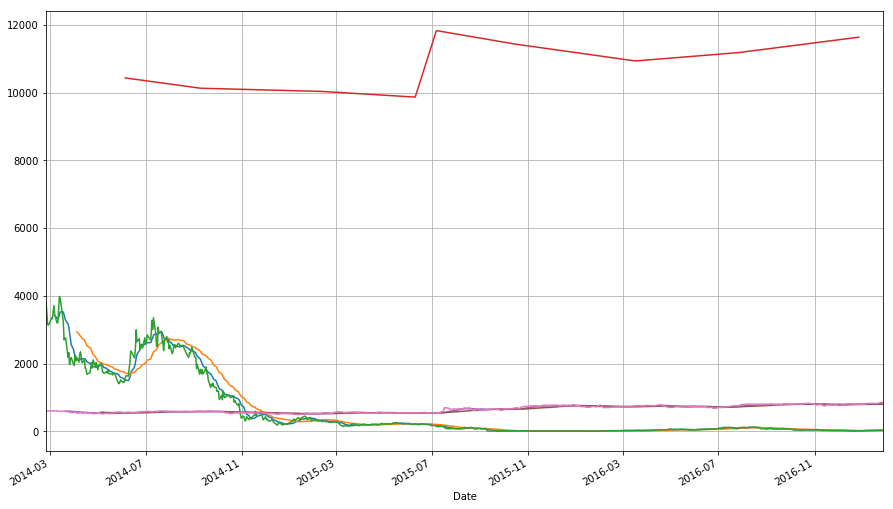

In [4]:
import pandas as pd
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import pylab
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY
from matplotlib.finance import candlestick_ohlc
import numpy as np



%matplotlib inline

pylab.rcParams['figure.figsize'] = (15, 9)   # Change the size of plots




startdate = datetime.datetime(2014,2,24)
enddate = datetime.datetime(2017, 1, 27)

jnug= web.DataReader("JNUG","google",startdate,enddate)
jdst = web.DataReader("GOOGL", "google", startdate, enddate)

jnug["10d"] =jnug["Close"].rolling(window=10, center = False).mean() #
jnug["30d"] =jnug["Close"].rolling(window=30, center = False).mean()


jnug["10d"].plot(grid=True)
jnug["30d"].plot(grid=True)
jnug["Close"].plot(grid=True)








adj_data = ohlc_adj(jdst)

# This next code repeats all the earlier analysis we did on the adjusted data
day1= "1d"
day2="2d"
dif="1d-2d"
adj_data[day1] = adj_data["Close"].rolling(window = 20, center = False).mean()
adj_data[day2] = adj_data["Close"].rolling(window = 50, center = False).mean()



adj_data[dif] = adj_data[day1] - adj_data[day2]



# np.where() is a vectorized if-else function, where a condition is checked for each component of a vector, and the first argument passed is used when the condition holds, and the other passed if it does not
adj_data["Regime"] = np.where(adj_data[dif] > 0, 1, 0)


# We have 1's for bullish regimes and 0's for everything else. Below I replace bearish regimes's values with -1, and to maintain the rest of the vector, the second argument is apple["Regime"]
adj_data["Regime"] = np.where(adj_data[dif] < 0, -1, adj_data["Regime"])
# To ensure that all trades close out, I temporarily change the regime of the last row to 0
regime_orig = adj_data.ix[-1, "Regime"]



adj_data.ix[-1, "Regime"] = 0
adj_data["Signal"] = np.sign(adj_data["Regime"] - adj_data["Regime"].shift(1))
# Restore original regime data
adj_data.ix[-1, "Regime"] = regime_orig



# Create a DataFrame with trades, including the price at the trade and the regime under which the trade is made.
adj_data_signals = pd.concat([
        pd.DataFrame({"Price": adj_data.loc[adj_data["Signal"] == 1, "Close"],
                     "Regime": adj_data.loc[adj_data["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": adj_data.loc[adj_data["Signal"] == -1, "Close"],
                     "Regime": adj_data.loc[adj_data["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])



adj_data_signals.sort_index(inplace = True)

#print (adj_data["Signal"])
#print (adj_data_signals)



adj_data_long_profits = pd.DataFrame({
        "Price": adj_data_signals.loc[(adj_data_signals["Signal"] == "Buy") &
                                  adj_data_signals["Regime"] == 1, "Price"],
        "Profit": pd.Series(adj_data_signals["Price"] - adj_data_signals["Price"].shift(1)).loc[
            adj_data_signals.loc[(adj_data_signals["Signal"].shift(1) == "Buy") & (adj_data_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": adj_data_signals["Price"].loc[
            adj_data_signals.loc[(adj_data_signals["Signal"].shift(1) == "Buy") & (adj_data_signals["Regime"].shift(1) == 1)].index
        ].index
    })







tradeperiods = pd.DataFrame({"Start": adj_data_long_profits.index,
                        "End": adj_data_long_profits["End Date"]})
#adj_data_long_profits["Low"] = tradeperiods.apply(lambda x: min(adj_data.loc[x["Start"]:x["End"], "Low"]), axis = 1)




cash = 10000
backtest = pd.DataFrame({"Start Port. Value": [],
                         "End Port. Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = 1  # Max proportion of portfolio bet on any trade
batch = 1      # Number of shares bought per batch
stoploss = .03   # % of trade loss that would trigger a stoploss
for index, row in adj_data_long_profits.iterrows():
    temp=adj_data.loc[index:row["End Date"], "Close"]
    batches = np.floor(cash * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    
    
    [stop_trig,share_profit]=profitt(temp,stoploss)
    
    
        #if row["Low"] < (1 - stoploss) * row["Price"]:   # Account for the stop-loss
        #share_profit = (1 - stoploss) * row["Profit"]
            
        #else:
            #share_profit = row["Profit"]
            #stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    backtest = backtest.append(pd.DataFrame({
                "Start Port. Value": cash,
                "End Port. Value": cash + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    cash = max(0, cash + profit)

backtest


n=len(backtest)
print (backtest)
beggining=backtest["Start Port. Value"][0]
ending=backtest["End Port. Value"][n-1]
v= ending-beggining
percentage= (v/beggining)*100
backtest["End Port. Value"].plot()


adj_data[day1].plot(grid=True)
adj_data[day2].plot(grid=True)
jdst["Close"].plot(grid=True)

In [10]:
techstocks= ["TSLA","AAPL","MSFT","GOOG","AMD","NVDA"]

nividia = web.DataReader("NVDA", "google", start, end)
amd = web.DataReader("AMD", "google", start, end)
tesla = web.DataReader("TSLA", "google", start, end)
apple = web.DataReader("AAPL", "google", start, end)
microsoft = web.DataReader("MSFT", "google", start, end)
google = web.DataReader("GOOG", "google", start, end)
SPY = web.DataReader("SPY", "google", start, end)
jdst=web.DataReader("JDST","google",start,end)
jnug= web.DataReader("JNUG","google",start,end)

rsiFunc(tesla)

start = datetime.datetime(2016,1,4)
end = datetime.date.today()



# Get more stocks
tesla = web.DataReader("TSLA", "yahoo", start, end)
google = web.DataReader("GOOG", "yahoo", start, end)
apple = web.DataReader("AAPL", "yahoo", start, end)
wellfargo = web.DataReader("WFC", "yahoo", start, end)
goldman = web.DataReader("GS", "yahoo", start, end)
bank = web.DataReader("BA", "yahoo", start, end)
jnug = web.DataReader("JNUG", "yahoo", start, end)
jdst = web.DataReader("JDST", "yahoo", start, end)
dgaz = web.DataReader("DGAZ", "yahoo", start, end)
ugaz = web.DataReader("UGAZ", "yahoo", start, end)
dust = web.DataReader("DUST", "yahoo", start, end)
ung = web.DataReader("UNG","yahoo", start, end)


#stocs=[("JNUG",  ohlc_adj(jnug)),("JDST",  ohlc_adj(jdst)),("DGAZ",  ohlc_adj(dgaz)),("UGAZ",  ohlc_adj(ugaz)),("DUST",  ohlc_adj(dust)),("UNG",  ohlc_adj(ung))]
stocs=[("TSLA",  ohlc_adj(tesla)),("GOOG",  ohlc_adj(google)),("AAPL",  ohlc_adj(apple)),("WFC",  ohlc_adj(wellfargo)),("GS",  ohlc_adj(goldman)),("BA",  ohlc_adj(bank))]
signals = ma_crossover_orders(stocs,
                            fast = 10, slow = 30)
signals


bk = backtest(signals, 100000)
bk

bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]).plot()
x=bk["Portfolio Value"].groupby(level=0).apply(lambda x:x[-1])
print ((x[-1]-100000)/100000)

#adj_data[].plot(grid=True)
#adj_data[].plot(grid=True)
fast=3
slow=8
fast_str = str(fast) + 'd'
slow_str = str(slow) + 'd'
for s in stocs:
    s[1][fast_str] = s[1]["Close"].rolling(window = fast, center = False).mean()
    x=s[1][fast_str]
    s[1][slow_str] = s[1]["Close"].rolling(window = slow, center = False).mean()
    y=s[1][slow_str]
x.plot()
y.plot()
dust["Adj Close"].plot(grid=True)


bolinger(tesla)

spyder = web.DataReader("SPY", "yahoo", start, end)

ax_bench = (spyder["Adj Close"] / spyder.ix[0, "Adj Close"]).plot(label = "SPY")
ax_bench = (bk["Portfolio Value"].groupby(level = 0).apply(lambda x: x[-1]) / 100000).plot(ax = ax_bench, label = "Portfolio")
ax_bench.legend(ax_bench.get_lines(), [l.get_label() for l in ax_bench.get_lines()], loc = 'best')
ax_bench

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()